In [1]:
from InSitu14CO import Propagator
import numpy as np
import matplotlib.pyplot as plt
import crflux.models as pm
import matplotlib.ticker as ticker
import matplotlib as mpl

In [2]:
axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0'
             }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

# The Propagator Class

An instance of the Propagator class sets up the depth and density profiles of the desired location, then uses these values to propagate primary Cosmic Rays (CRs) from the top of the atmosphere to muons at the surface and under the ice.

These muon fluxes are then used to calculate the production rate of Carbon-14, and finally the predicted concentration of $^{14}CO$ in the ice.

In [3]:
# Create an instance of the Propagator Class
# The default settings are for Dome C, Antarctica
Prop = Propagator()

In [4]:
# This method sets the elevation to 3216m, the elevation of Summit, Greenland
#Prop = Propagator(elev=3216)

## Ice Density Profile

The first thing to do when the Propagator is initialized is to set up the depth ($z$), mass depth ($h$), and time ($t$) bins.
These values can be input directly with a numpy array, or loaded from a .csv file.

For any given binned value X, the array X_bins records the edges of the bins, X is the averages, and dX is the bin widths.

In [5]:
# Load the real depth, ice-equivalent depth, and age scale of ice at Dome C, Antarctica
Prop.load_ice_profile('Real_vs_ice_eq_depth.csv', 'DomeC_age_scale_Apr2023.csv')

In [6]:
# This method directly loads the density of ice with depth, using data for Summit, Greenland
#Prop.load_density('Summit_Densities.csv', z_deep=400.)

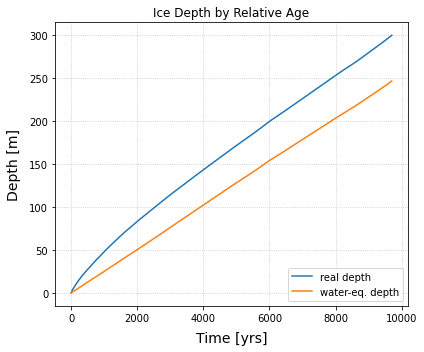

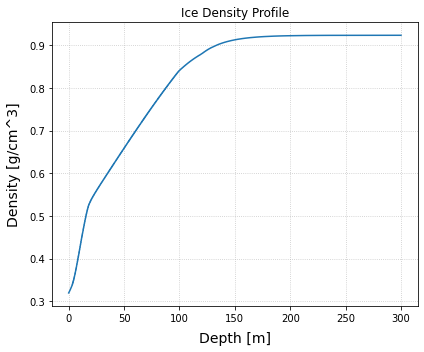

In [7]:
# Plot depth, mass depth, and time
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(Prop.t, Prop.z, label='real depth')
ax.plot(Prop.t, Prop.h, label='water-eq. depth')
ax.set(xlabel='Time [yrs]',
       ylabel='Depth [m]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Depth by Relative Age')
plt.show()

# Plot density
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(Prop.z, Prop.rho)
ax.set(xlabel='Depth [m]',
       ylabel='Density [g/cm^3]')
#ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Density Profile')
plt.show()

## Energy and Zenith Angle Bins

Next we establish the particle energies and zenith angles that are tracked by the Propagator.

Energies ($E$) are recorded in GeV, and the bins are logarithmically spaced with 10 bins per decade (*per factor of 10*).

Zenith angles ($\theta$) are saved as the cosine (cosTH), and the bins are evenly spaced in $\cos\theta$, and thus in solid angle (since $d\Omega = 2\pi\, d\cos\theta$)

All of this is done automatically when the Propagator is initialized, but it's instructive to show how it works and how to modify it.

In [8]:
# setup the energies, giving the bounds and bin-width in log10 GeV
Prop.set_energy_bins(logE_min = -1, logE_max = 11, dlogE = 0.1)

In [9]:
# setup the zenith angles
Prop.set_zenith_bins(N_ang=10)

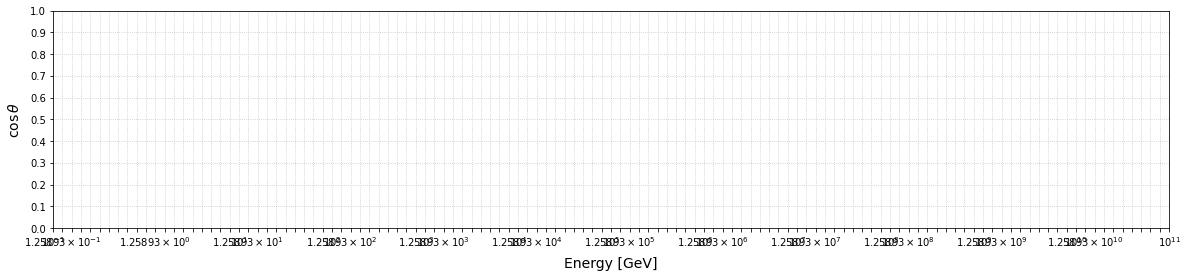

In [10]:
# plot Energy & Angle bins
fig, (ax) = plt.subplots(1,1, figsize=(20,4))
ax.set(xlim=(Prop.E_bins[0],Prop.E_bins[-1]),
       xscale='log',
       xlabel='Energy [GeV]',
       ylim=(Prop.cosTH[-1],Prop.cosTH[0]),
       yticks = Prop.cosTH_bins,
       ylabel=r'$\cos\theta$')

#for cth in Prop.cosTH:
    #ax.scatter(Prop.E,cth+Prop.E*0)

plt.xticks(Prop.E_bins)

plt.show()

# For my life, I can't figure out how to set the x-axis labels to only be on the decades

## Propagation Models

Now we want to set which methods we're using for each step of the calculation.  If we select multiple models for the same step, the final calculation will output the result of every possible combination of models.

Each model is given as a tuple like so:

`(function, (parameters))`

Where the function has the form:

`function(Input_flux, *parameters)`

In [11]:
# Clear all models
Prop.clear_models()

In [12]:
# primary CR -> atmospheric muons
atm = [(Prop.judge_nash, ()), (Prop.MCEq_atm, ()), (Prop.daemonflux_atm, ())]
atm_labels = ['JN-fit', 'MCEq-air', 'daemonflux']

# atmospheric muons -> underice muons
ice = [(Prop.Heisinger_ice, ()), (Prop.MCEq_ice, ())]
ice_labels = ['_H-ice', '_MCEq-ice']

# primary CR -> underice muons
atmice = []
atmice_labels = []

# underice muons -> 14C production rates
prod = [(Prop.Dyonisius_prod, ())]
prod_labels = ['']

# primary CR -> 14C production rates
prodfull = [(Prop.Heisinger_full, ())]
prodfull_labels = ['Heisinger']

# 14C production rates -> 14CO profile
flow = [(Prop.Basic_flow, ())]
flow_labels = ['']

# primary CR -> 14CO profile
flowfull = []
flowfull_labels = []

In [13]:
# Now we load our desired models into the Propagator
Prop.set_models(atm, atm_labels, ice, ice_labels, atmice, atmice_labels, prod, prod_labels, prodfull,
                prodfull_labels, flow, flow_labels, flowfull, flowfull_labels)

## Primary CR Flux

Now we setup an array of primary CR fluxes to start off our calculation.

`Phi0
axis0 - Primary Model (Energy spectrum & Time dependence)
axis1 - Particle Species (proton, neutron)
axis2 - Primary Energy`

In [14]:
# Load the Hillas Gaisser primary model
Prop.load_primary([(pm.HillasGaisser2012, "H3a")])

In [15]:
# Setup primary matrix to test each particle energy individually (akin to an Identity matrix)
#Prop.set_primary_identity()

## Calculation

Now we can run the calculation.  The Propagator starts from:

`Phi0 (Primary CR flux)
axis0 - Primary Model
axis1 - Particle Species (proton, neutron)
axis2 - Primary Energy (E)`

Using `atm` models to calculate:

`Phi_atm (Atmospheric muon flux)
axis0 - Atmospheric Model
axis1 - Primary Model
axis2 - Zenith Angle (cosTH)
axis3 - Muon Charge (positive, negative)
axis4 - Muon Energy (E)`

Then `ice` and `atmice` to calculate:

`Phi_ice (Underice muon flux)
axis0 - Atmospheric & Ice Models
axis1 - Primary Model
axis2 - Muon Charge (positive, negative)
axis3 - Muon Energy (E)
axis4 - depth bin EDGES (z_bins)`

Next `prod` and `prodfull` to get:

`P_14C (14C production rates)
axis0 - Production, Atmospheric & Ice Models
axis1 - Primary Model
axis2 - Production Mode (fast, neg)
axis3 - depth bin centers (z)`

And finally `flow` and `flowfull` give:

`CO (14CO profile)
axis0 - Flow, Production, Atmospheric & Ice Models
axis1 - Primary Model
axis2 - depth bin centers (z)`

In [16]:
# Run all models
Prop.calculate()

C:\Users\walte\Documents\python-scripts\In-Situ-14C\InSitu14CO.py:1089: RuntimeWarning: invalid value encountered in power
  W_K = (0.0874 * cosTH * (1- q * (y0/cosTH - 0.0874)/r_K/E_K))**(H_mu/cosTH/(r_K*E_K+90*q))


(1, 10, 2, 120)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.17s/it]


(1, 10, 2, 120)
(1, 10, 2, 120)
Atmosphere complete


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [30:04<00:00, 180.41s/it]

Ice complete


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:
# Plot all 14CO profiles
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5), tight_layout=True, sharex=True)

for i,c in enumerate(Prop.CO):
    ax1.plot(Prop.z[Prop.i_start:], c[0], label=Prop.model_names[i])
    ax2.plot(Prop.z[Prop.i_start:], c[0]/Prop.CO[-1,0])

ax1.set(#xlim=(z[i_int][0],z[i_int][-1]),
       xlabel='depth [m]',
       ylim=(0,30),
       ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax1.legend(loc='lower right', fontsize=8)

ax2.set(xlim=(Prop.z[Prop.i_start],Prop.z[-1]),
       xlabel='depth [m]',
       #ylim=(0.98,1.06),
       ylabel=r'$^{14}$CO ratio')
#ax2.legend(loc='best', fontsize=10)

plt.suptitle('In Situ 14CO Concentration over Depth')
plt.show()

## Loading Data Points

## Saving to csv

In [ ]:
#Prop.save_prod_to_csv('Matrices/')